In [1]:
import pandas as pd
!nvidia-smi

Tue Dec  2 10:35:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.102.01             Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:01:00.0  On |                  N/A |
| 36%   35C    P8             24W /  370W |   21954MiB /  24576MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
!unzip data.zip

--2025-12-02 08:25:53--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-02T09%3A17%3A58Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-02T08%3A17%3A07Z&ske=2025-12-02T09%3A17%3A58Z&sks=b&skv=2018-11-09&sig=grkZ%2Fjz5oMckwXIU%2FS7Ry%2FRNnbcVLBJYNrDLMp3UiHw%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDY2NTc1NCwibmJmIjoxNzY0NjYzOTU0LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlv

In [2]:
import numpy as np
import torch

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Question 1

## Which loss function you will use?

- nn.MSELoss()
- nn.BCEWithLogitsLoss()
- ## nn.CrossEntropyLoss()
- nn.CosineEmbeddingLoss()

## Model

For this homework we will use Convolutional Neural Network (CNN). We'll use PyTorch.

### You need to develop the model with following structure:

- The shape for input should be (3, 200, 200) (channels first format in PyTorch)

Next, create a convolutional layer (nn.Conv2d):

- Use 32 filters (output channels)
- Kernel size should be (3, 3) (that's the size of the filter), padding = 0, stride = 1
- Use 'relu' as activation

Reduce the size of the feature map with max pooling (nn.MaxPool2d)
- Set the pooling size to (2, 2)

Turn the multi-dimensional result into vectors using flatten or view

Next, add a nn.Linear layer with 64 neurons and 'relu' activation

Finally, create the nn.Linear layer with 1 neuron - this will be the output

The output layer should have an activation - use the appropriate activation for the binary classification case

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# This class defines a simple Convolutional Neural Network (CNN)
# for binary image classification in PyTorch.
# It takes RGB images of shape (3, 200, 200) and outputs
# a single probability (between 0 and 1) for the positive class.
class SimpleBinaryCNN(nn.Module):
    def __init__(self):
        # Initialize the base nn.Module class (required for all PyTorch models).
        super().__init__()

        # -------- Convolution + Pooling block --------
        # Conv2d applies learnable filters (kernels) over the input image.
        # in_channels=3  -> input has 3 channels (RGB image).
        # out_channels=32 -> we learn 32 different filters, so output has 32 channels.
        # kernel_size=3   -> each filter is 3x3 pixels (small local neighborhood).
        # stride=1        -> filter moves 1 pixel at a time (no skipping).
        # padding=0       -> no zero-padding; output becomes slightly smaller spatially.
        #
        # Input:  (N, 3, 200, 200)
        # Output: (N, 32, 198, 198)
        # because with kernel_size=3, stride=1, padding=0:
        # H_out = (H_in - kernel_size) / stride + 1 = (200 - 3) / 1 + 1 = 198 (same for W).
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=0
        )

        # MaxPool2d downsamples the feature map by taking the maximum value
        # in each non-overlapping window.
        # kernel_size=2 -> window is 2x2.
        # stride=2      -> move the window by 2 pixels, so windows do not overlap.
        #
        # This reduces height and width by a factor of 2:
        # Input:  (N, 32, 198, 198)
        # Output: (N, 32, 99, 99)
        #
        # Why use pooling?
        # - Reduces spatial size -> fewer parameters in later layers, faster training.
        # - Keeps strongest activations -> makes model more robust to small shifts. [web:55][web:68][web:70]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # -------- Fully connected (dense) layers --------
        # After conv + pooling, the tensor shape is (N, 32, 99, 99).
        # We will flatten it into a vector per example:
        # 32 channels * 99 height * 99 width = 313,632 features.
        #
        # This linear layer maps those 313,632 features down to 64 neurons.
        # This acts as a learned feature combiner: it mixes all local features
        # from the convolution block into a more compact representation.
        self.fc1 = nn.Linear(32 * 99 * 99, 64)

        # Final linear layer that maps from 64 features to 2 output value.
        # This single value (before activation) is often called a "logit".
        # We will then pass it through a sigmoid to get a probability.
        self.fc2 = nn.Linear(64, 1)

        # -------- Output activation for binary classification --------
        # Sigmoid squashes the output to the range (0, 1), so it can be interpreted
        # as a probability of the positive class (e.g., class "1").
        #
        # In practice, for numeric stability, it is common to:
        # - remove this Sigmoid in the model
        # - and use BCEWithLogitsLoss, which combines sigmoid + binary cross entropy. [web:12]
        # But for educational purposes, keeping Sigmoid here makes the model
        # output directly interpretable probabilities.
        # self.out_act = nn.Sigmoid()

    def forward(self, x):
        # x is the input batch of images with shape:
        # (N, 3, 200, 200), where
        #   N = batch size
        #   3 = number of channels (RGB)
        #   200, 200 = height and width in pixels

        # 1) Apply the convolutional layer.
        # This computes 32 filtered versions of the input image,
        # each highlighting different patterns (edges, textures, etc.).
        x = self.conv1(x)          # -> (N, 32, 198, 198)

        # 2) Apply ReLU activation.
        # ReLU(x) = max(0, x).
        # It keeps positive values and sets negative values to zero.
        # Why ReLU?
        # - Introduces non-linearity (model can learn more complex functions).
        # - Simple and efficient; helps mitigate vanishing gradients.
        x = F.relu(x)

        # 3) Apply max pooling.
        # This reduces spatial resolution by 2x in each dimension
        # while keeping the strongest activation in each 2x2 window.
        x = self.pool(x)           # -> (N, 32, 99, 99)

        # 4) Flatten the tensor from 4D to 2D.
        # We want a shape (N, num_features) to feed into the linear (fully connected) layers.
        # torch.flatten(x, 1) flattens all dimensions except the batch dimension.
        # So (N, 32, 99, 99) becomes (N, 32*99*99).
        x = torch.flatten(x, 1)    # -> (N, 32*99*99)

        # 5) First fully connected layer.
        # This learns to combine all extracted local features
        # into 64 higher-level features.
        x = self.fc1(x)            # -> (N, 64)

        # Apply ReLU again to add non-linearity between dense layers.
        x = F.relu(x)

        # 6) Second fully connected layer.
        # This maps the 64 features down to a single scalar per example.
        x = self.fc2(x)            # -> (N, 1)

        # 7) Sigmoid activation.
        # Converts the raw score (logit) into a probability in (0, 1).
        # This is suitable for binary classification:
        #   value close to 0 -> more likely class 0
        #   value close to 1 -> more likely class 1
        # x = self.out_act(x)        # -> (N, 1), values in (0, 1)

        # 8) Return the final predictions.
        return x


In [4]:
model = SimpleBinaryCNN()

# Binary cross-entropy with logits (inside it already has Sigmoid + BCELoss)
criterion = nn.BCEWithLogitsLoss()   # for binary classification with 1 logit

# SGD with parameters
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.002,
    momentum=0.8
)                                    # classical stocjastic gradient descend


## Question 2. Number of parameters

In [5]:
from torchsummary import summary
model = model.to('cuda')
summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
         MaxPool2d-2           [-1, 32, 99, 99]               0
            Linear-3                   [-1, 64]      20,072,512
            Linear-4                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 11.96
Params size (MB): 76.57
Estimated Total Size (MB): 89.00
----------------------------------------------------------------


In [11]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 20073473


## Generators and Training

For the next two questions, use the following transformation for both train and test sets:

```train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])
```

We don't need to do any additional pre-processing for the images.
Use batch_size=20
Use shuffle=True for both training, but False for test.

In [6]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 1) Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),      # resize all images to a fixed size (200x200)
    transforms.ToTensor(),              # convert PIL/NumPy image to a PyTorch tensor in [0, 1]
    transforms.Normalize(               # normalize each channel using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],     # this centers the data per channel
        std=[0.229, 0.224, 0.225]       # this scales the data per channel
    )
])


test_transforms = transforms.Compose([
    transforms.Resize((200, 200)),      # same resizing as for training data
    transforms.ToTensor(),              # same tensor conversion
    transforms.Normalize(               # same normalization (very important!)
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2) Create datasets
train_dataset = datasets.ImageFolder(
    root="data/train",
    transform=train_transforms
)

validation_dataset = datasets.ImageFolder(
    root="data/test",
    transform=test_transforms
)

# 3) Create DataLoaders with required settings
train_loader = DataLoader(
    train_dataset,
    batch_size=20,     # use batch_size = 20 for training
    shuffle=True,      # shuffle training data each epoch to improve learning
    num_workers=8,     # optional: number of worker processes for loading data
    pin_memory=True    # optional: speed up host-to-GPU transfers
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=20,     # same batch size for validation / test
    shuffle=False,     # do NOT shuffle test/validation data
    num_workers=8,
    pin_memory=True
)

"""
Why:

shuffle=True for training: helps the model see data in different orders each epoch, reduces overfitting to a specific order, and improves SGD behavior.​

shuffle=False for validation/test: keeps evaluation deterministic and aligned with dataset order (useful for debugging, saving predictions, etc.)
"""


'\nWhy:\n\nshuffle=True for training: helps the model see data in different orders each epoch, reduces overfitting to a specific order, and improves SGD behavior.\u200b\n\nshuffle=False for validation/test: keeps evaluation deterministic and aligned with dataset order (useful for debugging, saving predictions, etc.)\n'

## Now fit the model.

In [7]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()  # set model to training mode (enables dropout, batchnorm updates, etc.)
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # move data to the selected device (CPU or GPU)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        images, labels = images.to(device), labels.to(device)

        # BCEWithLogitsLoss expects float targets with the same shape as outputs
        # ImageFolder gives integer class indices (0 or 1), so we cast to float and add a channel dim
        labels = labels.float().unsqueeze(1)  # (batch_size,) -> (batch_size, 1)

        optimizer.zero_grad()        # reset gradients from the previous step
        outputs = model(images)      # forward pass, outputs are raw logits (no sigmoid)

        loss = criterion(outputs, labels)  # BCEWithLogitsLoss computes sigmoid + binary cross-entropy internally
        loss.backward()                   # backpropagate gradients
        optimizer.step()                  # update model parameters with SGD

        # accumulate training loss (multiply by batch size to later compute dataset average)
        running_loss += loss.item() * images.size(0)

        # for accuracy we convert logits to probabilities via sigmoid, then threshold at 0.5
        probs = torch.sigmoid(outputs)          # (batch_size, 1), values in (0, 1)
        predicted = (probs > 0.5).float()       # (batch_size, 1), 0.0 or 1.0

        total_train += labels.size(0)
        # labels and predicted have shape (batch_size, 1), so elementwise comparison is fine
        correct_train += (predicted == labels).sum().item()

    # compute average training loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    # ----- validation phase -----
    model.eval()  # set model to evaluation mode (disables dropout, uses running stats for batchnorm)
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # no gradient computation during validation
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)                  # raw logits
            loss = criterion(outputs, labels)        # same BCEWithLogitsLoss

            val_running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # average validation loss and accuracy
    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    # print epoch summary
    print(
        f"Epoch {epoch + 1}/{num_epochs}, "
        f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
        f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"
    )


Epoch 1/10, Loss: 0.6665, Acc: 0.6112, Val Loss: 0.6511, Val Acc: 0.6617
Epoch 2/10, Loss: 0.5702, Acc: 0.6787, Val Loss: 0.6332, Val Acc: 0.6318
Epoch 3/10, Loss: 0.5207, Acc: 0.7350, Val Loss: 0.6143, Val Acc: 0.6766
Epoch 4/10, Loss: 0.4773, Acc: 0.7600, Val Loss: 0.6049, Val Acc: 0.6617
Epoch 5/10, Loss: 0.4606, Acc: 0.7550, Val Loss: 0.7307, Val Acc: 0.5672
Epoch 6/10, Loss: 0.3954, Acc: 0.8275, Val Loss: 0.6412, Val Acc: 0.6866
Epoch 7/10, Loss: 0.2844, Acc: 0.8838, Val Loss: 0.8307, Val Acc: 0.6816
Epoch 8/10, Loss: 0.2885, Acc: 0.8788, Val Loss: 0.7052, Val Acc: 0.7114
Epoch 9/10, Loss: 0.1882, Acc: 0.9313, Val Loss: 0.9275, Val Acc: 0.6866
Epoch 10/10, Loss: 0.2585, Acc: 0.8912, Val Loss: 0.8158, Val Acc: 0.6915


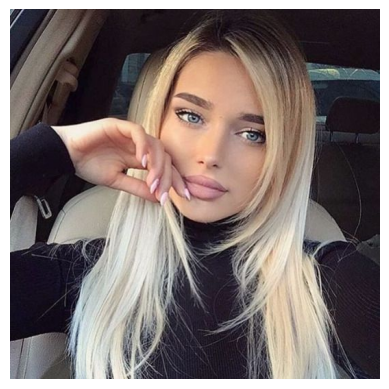

In [47]:
image_path = "data/test/straight/e374f7844815aaeb27d48dac10c5e9ff.jpg"
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open(image_path).convert("RGB")

# show the original image
plt.imshow(img)
plt.axis("off")
plt.show()

In [48]:
single_image_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# apply transforms to PIL image
tensor_img = single_image_transforms(img)   # shape: (3, 200, 200)

# add batch dimension: model expects (N, C, H, W)
tensor_img = tensor_img.unsqueeze(0)        # shape: (1, 3, 200, 200)
tensor_img = tensor_img.to(device)          # move to same device as model (cpu/cuda

In [ ]:
model.eval()  # eval mode for inference (turn off dropout, etc.)

In [50]:

with torch.no_grad():  # no gradients needed for inference
    logits = model(tensor_img)          # shape: (1, 1), raw logits
    probs = torch.sigmoid(logits)       # convert logits -> probability in (0, 1)
    prob = probs.item()                 # python float

# choose class based on 0.5 threshold
pred_label = 1 if prob >= 0.5 else 0

print(f"Predicted probability for straight 1: {prob:.4f}")
print(f"Predicted class: {pred_label}")

Predicted probability for straight 1: 0.7968
Predicted class: 1


## Question 3.

Median of training accuracy for all the epochs

In [9]:
training_accuracy = history['acc']
median_training_accuracy = np.median(training_accuracy)
median_training_accuracy

np.float64(0.79375)

## Question 4.

Standard deviation of training loss for all the epochs

In [10]:
test_loss = history['loss']
std_test_loss = np.std(test_loss, ddof=0)
std_test_loss

np.float64(0.14617673676881032)

## Data Augmentation

In [11]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(50),                       # randomly rotate image within ±50 degrees
    transforms.RandomResizedCrop(
        200,                                             # output size: 200x200 (matches your model)
        scale=(0.9, 1.0),                                # random crop covers 90–100% of original area
        ratio=(0.9, 1.1)                                 # random aspect ratio between 0.9 and 1.1
    ),
    transforms.RandomHorizontalFlip(),                   # randomly flip image left-right with p=0.5
    transforms.Resize((200, 200)),
    transforms.ToTensor(),                               # convert PIL image to tensor in [0, 1]
    transforms.Normalize(                                # ImageNet normalization (same as before)
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

## Let's train our model for 10 more epochs using the same code as previously.

Note: make sure you don't re-create the model. we want to continue training the model we already started training.

In [51]:
extra_epochs = 20

for epoch in range(num_epochs, num_epochs + extra_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)                  # forward with existing weights
        loss = criterion(outputs, labels)        # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()                         # continues updating same weights

        running_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(
        f"Epoch {epoch + 1}, "
        f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
        f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"
    )


Epoch 11, Loss: 0.0042, Acc: 1.0000, Val Loss: 1.1934, Val Acc: 0.7214
Epoch 12, Loss: 0.0036, Acc: 1.0000, Val Loss: 1.1941, Val Acc: 0.7363
Epoch 13, Loss: 0.0033, Acc: 1.0000, Val Loss: 1.2100, Val Acc: 0.7363
Epoch 14, Loss: 0.0029, Acc: 1.0000, Val Loss: 1.2218, Val Acc: 0.7413
Epoch 15, Loss: 0.0027, Acc: 1.0000, Val Loss: 1.2514, Val Acc: 0.7313
Epoch 16, Loss: 0.0025, Acc: 1.0000, Val Loss: 1.2671, Val Acc: 0.7363
Epoch 17, Loss: 0.0022, Acc: 1.0000, Val Loss: 1.2790, Val Acc: 0.7313
Epoch 18, Loss: 0.0020, Acc: 1.0000, Val Loss: 1.2692, Val Acc: 0.7413
Epoch 19, Loss: 0.0019, Acc: 1.0000, Val Loss: 1.2961, Val Acc: 0.7313
Epoch 20, Loss: 0.0018, Acc: 1.0000, Val Loss: 1.3065, Val Acc: 0.7313
Epoch 21, Loss: 0.0017, Acc: 1.0000, Val Loss: 1.3109, Val Acc: 0.7413
Epoch 22, Loss: 0.0016, Acc: 1.0000, Val Loss: 1.3248, Val Acc: 0.7363
Epoch 23, Loss: 0.0015, Acc: 1.0000, Val Loss: 1.3472, Val Acc: 0.7313
Epoch 24, Loss: 0.0014, Acc: 1.0000, Val Loss: 1.3454, Val Acc: 0.7313
Epoch 

## Question 5

What is the mean of test loss for all the epochs for the model trained with augmentations?



In [20]:
import pandas as pd
df = pd.DataFrame(history)
df

,acc,loss,val_acc,val_loss
0,0.61125,0.666476,0.661692,0.651091
1,0.67875,0.570171,0.631841,0.633247
2,0.73500,0.520697,0.676617,0.614265
3,0.76000,0.477284,0.661692,0.604877
4,0.75500,0.460584,0.567164,0.730717
5,0.82750,0.395377,0.686567,0.641189
6,0.88375,0.284402,0.681592,0.830676
7,0.87875,0.288518,0.711443,0.705198
8,0.93125,0.188182,0.686567,0.927464
9,0.89125,0.258466,0.691542,0.815797


In [21]:
mean_test_loss = np.median( history['val_loss'])
mean_test_loss

np.float64(0.8327151817542997)

## Question 6

What's the average of test accuracy for the last 5 epochs (from 6 to 10) for the model trained with augmentations?



In [29]:
mean_test_accuracy = np.median(history['val_acc'][-5:])
mean_test_accuracy

np.float64(0.7313432835820896)

In [53]:
torch.save(model.state_dict(), "data/model_0.7313.pth")

## Model with dropout:

In [54]:
class SimpleBinaryCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 99 * 99, 64)
        self.fc2 = nn.Linear(64, 1)

        # Dropout layer: p is the probability to drop (zero out) a unit during training
        self.dropout = nn.Dropout(p=0.5)   # 50% dropout is a common starting point [web:201][web:207]

    def forward(self, x):
        # convolutional block
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        # flatten before fully connected layers
        x = torch.flatten(x, 1)

        # first fully connected layer + ReLU
        x = self.fc1(x)
        x = F.relu(x)

        # apply dropout only on the hidden representation
        x = self.dropout(x)    # this is active in model.train(), inactive in model.eval() [web:201][web:205]

        # output layer (logit for BCEWithLogitsLoss)
        x = self.fc2(x)
        return x


In [55]:
model = SimpleBinaryCNN().to(device)   # если нужно пересоздать с дропаутом
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0015, momentum=0.8)


In [56]:
num_epochs = 40
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}
import os

for epoch in range(num_epochs):
    model.train()  # set model to training mode (enables dropout, batchnorm updates, etc.)
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # move data to the selected device (CPU or GPU)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        images, labels = images.to(device), labels.to(device)

        # BCEWithLogitsLoss expects float targets with the same shape as outputs
        # ImageFolder gives integer class indices (0 or 1), so we cast to float and add a channel dim
        labels = labels.float().unsqueeze(1)  # (batch_size,) -> (batch_size, 1)

        optimizer.zero_grad()        # reset gradients from the previous step
        outputs = model(images)      # forward pass, outputs are raw logits (no sigmoid)

        loss = criterion(outputs, labels)  # BCEWithLogitsLoss computes sigmoid + binary cross-entropy internally
        loss.backward()                   # backpropagate gradients
        optimizer.step()                  # update model parameters with SGD

        # accumulate training loss (multiply by batch size to later compute dataset average)
        running_loss += loss.item() * images.size(0)

        # for accuracy we convert logits to probabilities via sigmoid, then threshold at 0.5
        probs = torch.sigmoid(outputs)          # (batch_size, 1), values in (0, 1)
        predicted = (probs > 0.5).float()       # (batch_size, 1), 0.0 or 1.0

        total_train += labels.size(0)
        # labels and predicted have shape (batch_size, 1), so elementwise comparison is fine
        correct_train += (predicted == labels).sum().item()

    # compute average training loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    # ----- validation phase -----
    model.eval()  # set model to evaluation mode (disables dropout, uses running stats for batchnorm)
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    best_val_loss = float("inf")  # start with +infinity
    best_model_path = "best_model.pth"

    with torch.no_grad():  # no gradient computation during validation
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)                  # raw logits
            loss = criterion(outputs, labels)        # same BCEWithLogitsLoss

            val_running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # average validation loss and accuracy
    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    # --- model checkpoint: save best model by validation loss ---
    # --- save best model with epoch and val_acc in filename ---
    save_dir = "checkpoints"
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss

        # build filename: e.g. model_epoch10_valacc0.73.pth
        epoch_num = epoch + 1                      # human-readable epoch index
        acc_str = f"{val_epoch_acc:.2f}"           # 0.73 style
        filename = f"model_epoch{epoch_num}_valacc{acc_str}.pth"
        best_model_path = os.path.join(save_dir, filename)

        print(f"New best val loss: {best_val_loss:.4f}. Saving to {best_model_path}")
        torch.save(model.state_dict(), best_model_path)   # save weights only

    # print epoch summary
    print(
        f"Epoch {epoch + 1}/{num_epochs}, "
        f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
        f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"
    )


New best val loss: 0.6248. Saving to checkpoints/model_epoch1_valacc0.64.pth
Epoch 1/40, Loss: 0.6957, Acc: 0.6050, Val Loss: 0.6248, Val Acc: 0.6368
New best val loss: 0.6042. Saving to checkpoints/model_epoch2_valacc0.62.pth
Epoch 2/40, Loss: 0.6001, Acc: 0.6675, Val Loss: 0.6042, Val Acc: 0.6219
New best val loss: 0.5919. Saving to checkpoints/model_epoch3_valacc0.68.pth
Epoch 3/40, Loss: 0.5676, Acc: 0.6887, Val Loss: 0.5919, Val Acc: 0.6766
New best val loss: 0.5862. Saving to checkpoints/model_epoch4_valacc0.66.pth
Epoch 4/40, Loss: 0.5595, Acc: 0.6863, Val Loss: 0.5862, Val Acc: 0.6617
New best val loss: 0.5920. Saving to checkpoints/model_epoch5_valacc0.65.pth
Epoch 5/40, Loss: 0.5431, Acc: 0.7225, Val Loss: 0.5920, Val Acc: 0.6517
New best val loss: 0.6276. Saving to checkpoints/model_epoch6_valacc0.63.pth
Epoch 6/40, Loss: 0.5111, Acc: 0.7338, Val Loss: 0.6276, Val Acc: 0.6269
New best val loss: 0.6080. Saving to checkpoints/model_epoch7_valacc0.66.pth
Epoch 7/40, Loss: 0.500